# Import the packages

In [76]:
# Python
import os
import glob 
import random
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import IPython.display as ipd

## Tensorflow
import tensorflow as tf
from matplotlib.pyplot import specgram
from tensorflow import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils

## Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

# Access the Data

In [15]:
prefix_path = '/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors_01-24/'
mylist = os.listdir(prefix_path)
mylist.sort()
print(mylist)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [16]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in mylist:
    file_list = os.listdir(prefix_path + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = prefix_path + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [17]:
print(len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,1,1,0,8
1,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,0,0,0,8
2,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,0,1,0,5
3,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,0,1,1,6
4,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,1,0,1,6


# Plot the audio's waveform and spectrogram

In [19]:
filename = data_df.path[1021]
print(filename)

samples, sample_rate = librosa.load(filename)
print(samples)

/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors_01-24/Actor_18/03-01-03-01-02-02-18.wav
[0. 0. 0. ... 0. 0. 0.]


In [20]:
len(samples)

77253

In [21]:
sample_rate

22050

In [24]:
def log_specgram(audio, sample_rate, window_size = 20,
                step_size = 10, eps = 1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                           fs = sample_rate,
                                           window = 'hann',
                                           nperseg = nperseg,
                                           noverlap = noverlap,
                                           detrend = False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [25]:
sample_rate / len(samples)

0.285425808706458

Text(0.5, 0, 'Seconds')

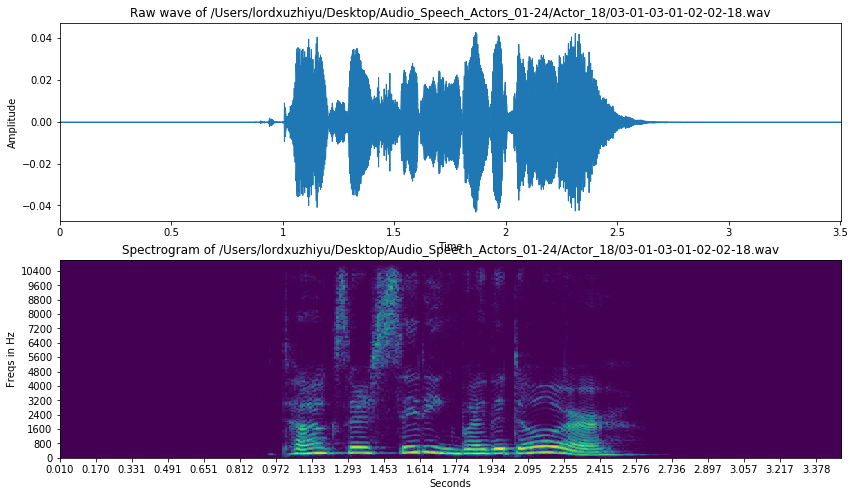

In [26]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [27]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [28]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-1.2785306e-05, -6.4177104e-05, -7.3851414e-05, ...,
         2.7482898e-04,  2.5709500e-04,  2.5484394e-04], dtype=float32),
 array([21504, 57856]))

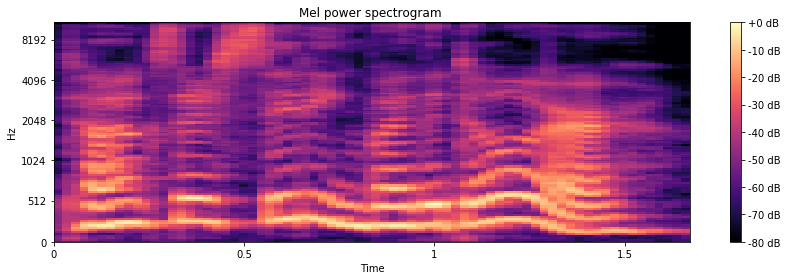

In [29]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

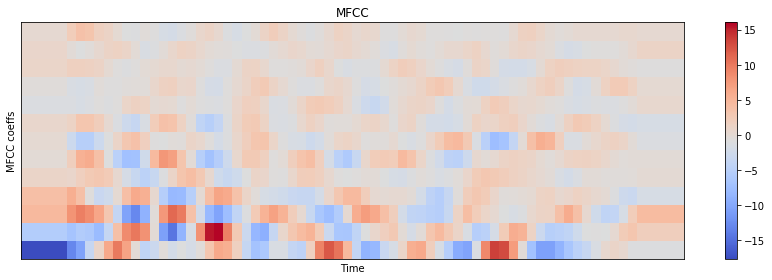

In [30]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [31]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [32]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [33]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# Define the truth label

In [34]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1440

In [35]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [36]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [37]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [38]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,1,1,0,8,male_none
1,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,0,0,0,8,male_none
2,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,0,1,0,5,male_negative
3,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,0,1,1,6,male_negative
4,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,1,0,1,6,male_negative


In [40]:
print(data_df.label.value_counts().keys())

Index(['male_negative', 'female_negative', 'male_none', 'female_none',
       'female_positive', 'male_positive'],
      dtype='object')


In [41]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

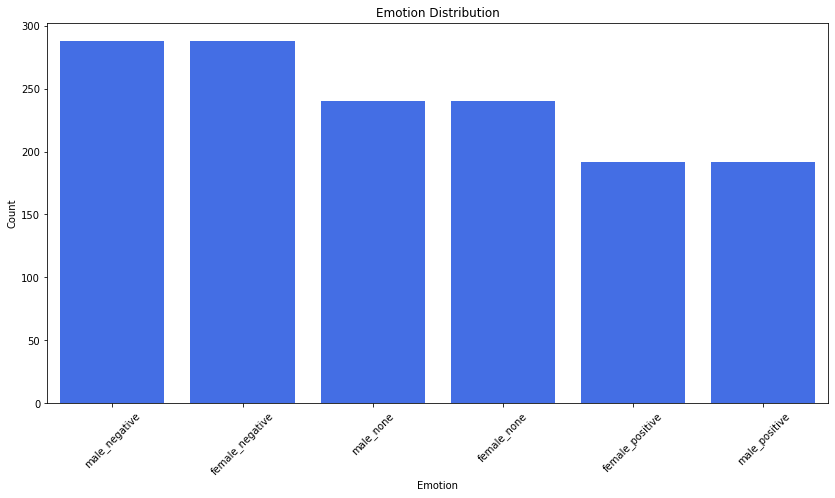

In [42]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# Data Preprocess

In [43]:
# Male Data Set

## Uncomment all below to use Male set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

400


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,0,1,0,5,male_negative
1,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,0,1,1,6,male_negative
2,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,1,0,1,6,male_negative
3,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,1,0,0,5,male_negative
4,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,1,male,0,0,1,4,male_negative


In [44]:
print (len(data3_df))
data3_df.head()

80


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,21,male,0,0,1,6,male_negative
1,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,21,male,0,0,0,5,male_negative
2,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,21,male,1,1,0,5,male_negative
3,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,21,male,1,1,1,6,male_negative
4,/Users/lordxuzhiyu/Desktop/Audio_Speech_Actors...,1,21,male,0,1,1,4,male_negative


# Features of Audio Files

In [46]:
data = pd.DataFrame(columns=['feature'])
input_duration = 3 

for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 400/400 [00:13<00:00, 30.77it/s]


In [47]:
data.head()

,feature
0,"[-55.663082, -56.17034, -56.157845, -54.663475..."
1,"[-63.523525, -63.523525, -63.523525, -63.52352..."
2,"[-43.19739, -44.238605, -43.99621, -44.13235, ..."
3,"[-42.991745, -42.991745, -42.845966, -42.26785..."
4,"[-67.73615, -67.77802, -66.74614, -65.95788, -..."


In [48]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [49]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-55.663082,-56.170341,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,-56.156944,-56.156944,-56.156944,-56.156944,-55.557552,-54.967789,-56.156944,-56.156944,-54.898682,-55.319336
1,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377373,-61.595852,-63.160221,-63.523525,-63.523525,...,-63.889992,-63.725601,-62.940960,-63.046490,-63.523525,-63.523525,-63.523525,-62.370121,-61.950607,-63.523525
2,-43.197392,-44.238605,-43.996208,-44.132351,-44.267864,-44.346035,-44.142899,-44.255207,-43.666569,-43.591591,...,-40.030666,-40.667133,-38.647114,-38.187950,-39.104439,-41.083157,-39.765224,-41.423752,-43.453789,-43.185627
3,-42.991745,-42.991745,-42.845966,-42.267849,-40.690151,-40.163383,-40.072178,-42.603897,-41.733139,-41.410770,...,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745
4,-67.736153,-67.778023,-66.746140,-65.957878,-67.736153,-67.736153,-67.736153,-67.258682,-67.736153,-67.736153,...,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153


In [50]:
newdf = pd.concat([df3,labels], axis=1)
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

400

In [51]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-55.663082,-56.170341,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,-56.156944,-56.156944,-56.156944,-55.557552,-54.967789,-56.156944,-56.156944,-54.898682,-55.319336,male_negative
1,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377373,-61.595852,-63.160221,-63.523525,-63.523525,...,-63.725601,-62.940960,-63.046490,-63.523525,-63.523525,-63.523525,-62.370121,-61.950607,-63.523525,male_negative
2,-43.197392,-44.238605,-43.996208,-44.132351,-44.267864,-44.346035,-44.142899,-44.255207,-43.666569,-43.591591,...,-40.667133,-38.647114,-38.187950,-39.104439,-41.083157,-39.765224,-41.423752,-43.453789,-43.185627,male_negative
3,-42.991745,-42.991745,-42.845966,-42.267849,-40.690151,-40.163383,-40.072178,-42.603897,-41.733139,-41.410770,...,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,male_negative
4,-67.736153,-67.778023,-66.746140,-65.957878,-67.736153,-67.736153,-67.736153,-67.258682,-67.736153,-67.736153,...,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,male_negative
5,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,...,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,male_negative
6,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,...,-55.771042,-55.095364,-54.868393,-53.707981,-55.067471,-57.414993,-57.414993,-56.832737,-55.191196,male_positive
7,-60.369041,-60.083717,-60.978920,-60.952454,-60.982483,-60.983948,-60.981255,-60.981255,-60.981255,-60.249615,...,-60.981255,-60.981255,-60.981255,-60.981255,-60.981255,-60.981255,NaN,NaN,NaN,male_positive
8,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive
9,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620766,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383522,-69.693306,-69.693306,-69.693306,-69.693306,male_positive


In [52]:
rnewdf.isnull().sum().sum()

2284

In [53]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-55.663082,-56.170341,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,-56.156944,-56.156944,-56.156944,-55.557552,-54.967789,-56.156944,-56.156944,-54.898682,-55.319336,male_negative
1,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377373,-61.595852,-63.160221,-63.523525,-63.523525,...,-63.725601,-62.940960,-63.046490,-63.523525,-63.523525,-63.523525,-62.370121,-61.950607,-63.523525,male_negative
2,-43.197392,-44.238605,-43.996208,-44.132351,-44.267864,-44.346035,-44.142899,-44.255207,-43.666569,-43.591591,...,-40.667133,-38.647114,-38.187950,-39.104439,-41.083157,-39.765224,-41.423752,-43.453789,-43.185627,male_negative
3,-42.991745,-42.991745,-42.845966,-42.267849,-40.690151,-40.163383,-40.072178,-42.603897,-41.733139,-41.410770,...,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,male_negative
4,-67.736153,-67.778023,-66.746140,-65.957878,-67.736153,-67.736153,-67.736153,-67.258682,-67.736153,-67.736153,...,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,male_negative


# Data Augmentation

In [54]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

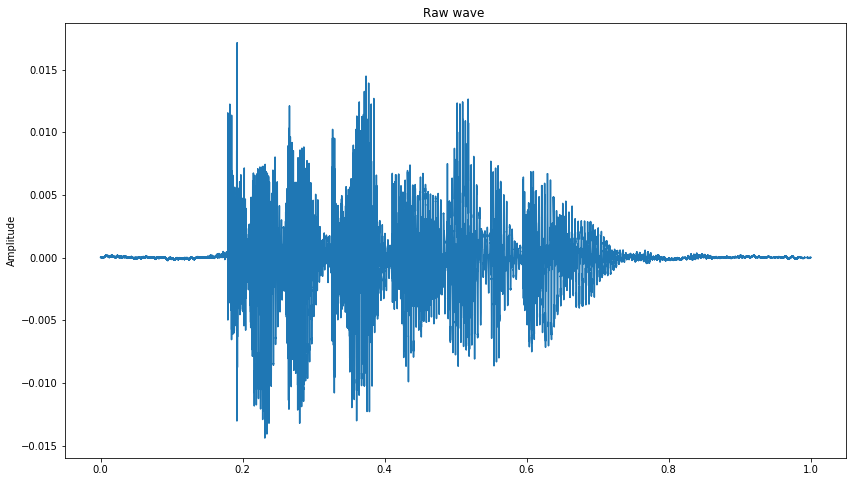

In [55]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

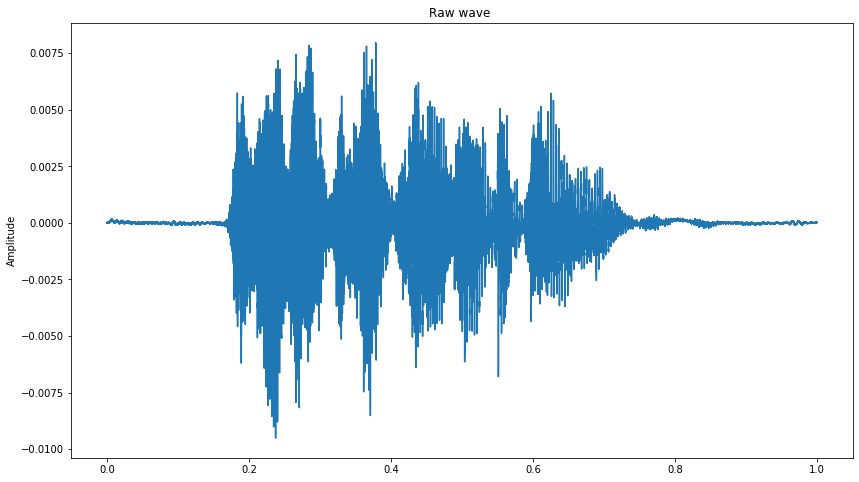

In [56]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [59]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [00:14<00:00, 27.33it/s]


In [60]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [01:06<00:00,  6.22it/s]


In [61]:
len(syn_data1), len(syn_data2)

(400, 400)

In [62]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [63]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

400

In [64]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-54.260677,-54.272724,-53.942585,-53.634834,-53.901386,-55.453922,-55.178017,-55.883610,-55.723991,-56.127522,...,-55.563766,-55.703270,-55.912979,-55.629501,-54.740704,-55.215370,-55.873047,-55.233421,-55.197411,male_negative
1,-50.951084,-51.349602,-50.437035,-50.071465,-51.078712,-52.681400,-50.242283,-49.741253,-50.368111,-48.397781,...,-51.445694,-51.434349,-52.593994,-50.607891,-49.364204,-49.525150,-50.719254,-52.110371,-53.324547,male_negative
2,-34.334641,-32.762676,-32.549870,-35.306999,-38.171818,-37.463184,-36.963955,-34.411339,-32.363232,-32.638443,...,-36.546177,-36.381271,-33.770157,-33.571659,-35.745609,-31.913675,-32.878990,-35.354019,-33.746578,male_negative
3,-37.846954,-39.143311,-38.944939,-39.219582,-37.564480,-37.818253,-38.230320,-38.841721,-37.802280,-39.710125,...,-38.676296,-39.641399,-38.887543,-40.241051,-38.821949,-38.871952,-40.084785,-37.830158,-39.184513,male_negative
4,-64.371918,-62.429955,-61.022015,-61.517063,-60.356441,-61.628540,-62.019852,-60.963585,-60.295406,-59.759396,...,-61.383358,-61.459213,-63.808273,-65.214928,-62.576958,-61.353130,-60.160580,-62.128677,-66.300545,male_negative


In [65]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

400

In [66]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-57.760555,-59.539001,-58.457211,-58.375263,-60.146355,-60.130276,-60.130276,-60.130276,-60.130276,-60.130276,...,-60.130276,-60.130276,-60.023705,-59.418545,-59.762444,-59.359524,-59.060547,-59.209671,-59.242088,male_negative
1,-66.392960,-66.432228,-66.432228,-66.432228,-66.432228,-65.712662,-65.539948,-66.225571,-66.432228,-66.432228,...,-66.520569,-66.379341,-66.470459,-66.432228,-66.432228,-66.155434,-66.379402,-66.566574,-66.469025,male_negative
2,-44.008274,-46.862999,-49.061588,-48.749596,-48.768414,-48.325741,-48.532860,-49.568710,-49.522346,-49.406250,...,-44.961235,-46.012321,-46.542789,-46.341003,-47.955421,-48.970047,-47.908737,-47.430183,-49.688545,male_negative
3,-46.885147,-47.515297,-48.542076,-47.178123,-46.315018,-45.022320,-43.732948,-45.519352,-44.967712,-43.194660,...,-46.885147,-46.885147,-46.885147,-46.885147,-46.885147,-46.885147,-46.885147,-46.885147,-46.885147,male_negative
4,-71.051552,-71.113533,-70.586716,-70.151047,-70.936584,-70.992889,-70.992889,-70.547218,-70.744698,-70.992889,...,-70.992889,-70.992889,-70.992889,-70.992889,-70.992889,-70.992889,-70.992889,-70.992889,-70.992889,male_negative


In [67]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-55.663082,-56.170341,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,-56.156944,-56.156944,-56.156944,-55.557552,-54.967789,-56.156944,-56.156944,-54.898682,-55.319336,male_negative
1,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377373,-61.595852,-63.160221,-63.523525,-63.523525,...,-63.725601,-62.940960,-63.046490,-63.523525,-63.523525,-63.523525,-62.370121,-61.950607,-63.523525,male_negative
2,-43.197392,-44.238605,-43.996208,-44.132351,-44.267864,-44.346035,-44.142899,-44.255207,-43.666569,-43.591591,...,-40.667133,-38.647114,-38.187950,-39.104439,-41.083157,-39.765224,-41.423752,-43.453789,-43.185627,male_negative
3,-42.991745,-42.991745,-42.845966,-42.267849,-40.690151,-40.163383,-40.072178,-42.603897,-41.733139,-41.410770,...,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,male_negative
4,-67.736153,-67.778023,-66.746140,-65.957878,-67.736153,-67.736153,-67.736153,-67.258682,-67.736153,-67.736153,...,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,male_negative


In [70]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [71]:
y_train.value_counts()

male_negative    576
male_positive    384
Name: label, dtype: int64

In [73]:
y_test.value_counts()

male_negative    144
male_positive     96
Name: label, dtype: int64

In [74]:
X_train.isna().sum().sum()

0

In [78]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = utils.to_categorical(lb.fit_transform(y_train))
y_test = utils.to_categorical(lb.fit_transform(y_test))

In [79]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [80]:
X_train.shape

(960, 259)